<center>
    <p align="center">
        <img src="https://logodownload.org/wp-content/uploads/2017/09/mackenzie-logo-3.png" style="height: 7ch;"><br>
        <h1 align="center">Computer Systems Undergradute Thesis</h1>
        <h2 align="center">Analysis of the Impact of Image Pre-Processing on the Accuracy of Computer Vision Models Trained to Identify Dermatological Skin Diseases</a>
        <h4 align="center">Gabriel Mitelman Tkacz</a>
        </h4>
    </p>
</center>

<hr>

In [1]:
import tomllib
from functools import partial
from pprint import pprint
from random import randint

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from util import *

In [2]:
with open('parameters.toml', 'r') as f:
    parameters = tomllib.loads(f.read())
    
pprint(parameters)

{'TRAINING': {'batch_size': 32,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'num_epochs': 10,
              'num_workers': 4,
              'pin_memory': True,
              'precision_threshold': 0.9,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_ratio = parameters['TRAINING']['training_dataset_ratio']
testing_ratio = round(1 - training_ratio, 1)

print(f'Training ratio: {training_ratio*100}%')
print(f'Testing ratio: {testing_ratio*100}%')

seed = randint(0, 1000)
print(f'\nSeed: {seed}')


Training ratio: 80.0%
Testing ratio: 20.0%

Seed: 895


In [5]:
def get_model_data(transform: transforms.Compose = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])) -> tuple[TrainingDataset, DataLoader, TestingDataset, DataLoader]:
    """
    This function returns the training and testing data loaders and datasets for the skin disease dataset.

    Args:
        transform (transforms.Compose, optional): The transformations to apply to the images. Defaults to transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]).

    Returns:
        dict[str, dict[str, DataLoader | SkinDiseaseDataset]]: A dictionary containing the training and testing data loaders and datasets.
    """
    loader_kwargs = {
                        'batch_size': parameters['TRAINING']['batch_size'],
                        'shuffle': parameters['TRAINING']['shuffle'],
                        'num_workers': parameters['TRAINING']['num_workers'],
                        'pin_memory': parameters['TRAINING']['pin_memory']
                     }

    base_dataset = SkinDiseaseDataset(root_dir='dataset', transform=transform)
    train_dataset, test_dataset = split_datasets(base_dataset, training_ratio, testing_ratio, seed)

    train_loader = DataLoader(train_dataset, **loader_kwargs)
    test_loader = DataLoader(test_dataset, **loader_kwargs)

    return train_dataset, train_loader, test_dataset, test_loader


def evaluate_model(criterion: LossFunction, device: torch.device, train_loader: DataLoader, test_loader: DataLoader) -> float:
    """
    This function evaluates the model using the given criterion and data loaders.

    Args:
        criterion (LossFunction): The loss function to use for the evaluation.
        device (torch.device): The device to use for the evaluation.
        train_loader (DataLoader): The training data loader.
        test_loader (DataLoader): The testing data loader.

    Returns:
        float: The accuracy of the model.
    """
    model = BinaryCNN(device=device).to(device)
    optimizer = optim.Adam(model.parameters())

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle('Sample images from the training dataset')

    for i, (image, label) in enumerate(train_loader):
        ax[i].imshow(image[0].permute(1, 2, 0))
        ax[i].set_title(f'Label: {"diseased" if label[0] else "healthy"}')
        ax[i].axis('off')

        if i == 2:
            break

    plt.show()

    train_model(criterion=criterion, device=device, verbose=False, model=model, optimizer=optimizer, data_loader=train_loader)

    return test_model(model, test_loader, device)

## Class 0 Model: Images with no pre-processing

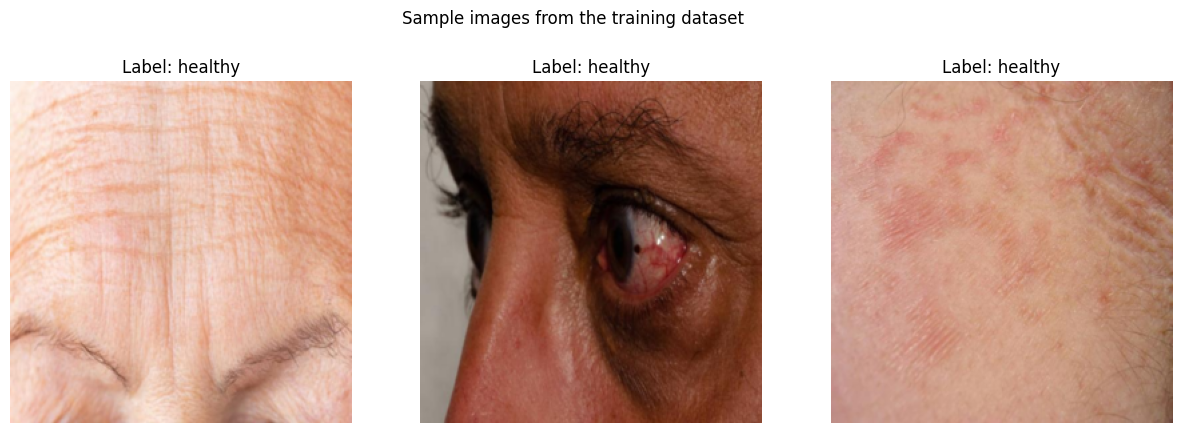

Base precision: 54.42%


In [6]:
base_train_dataset, base_train_loader, base_test_dataset, base_test_loader = get_model_data()
base_precision = evaluate_model(nn.BCELoss().to(device), device, base_train_loader, base_test_loader)
print(f'Base precision: {base_precision*100:.2f}%')

## Class 1 Models: Images with only one pre-process

### Class 1.1 Models: Normalizing the image


Normalizing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


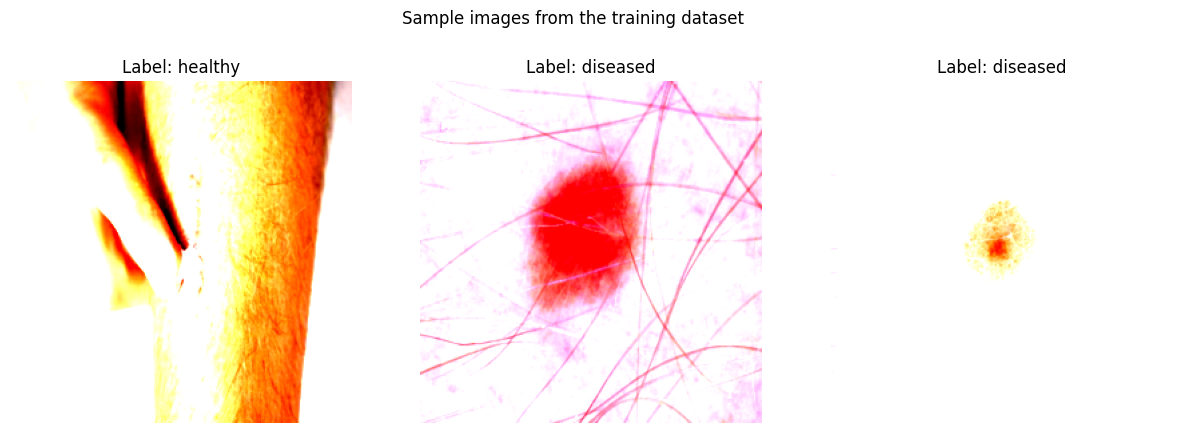

Precision: 54.42%
Improvement: 0.00%
The method is not an improvement.
--------------------



In [7]:
print(f'\nNormalizing')

train_dataset, train_loader, test_dataset, test_loader = get_model_data(transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.25, 0.25, 0.25], std=[0.25, 0.25, 0.25])]))

precision = evaluate_model(nn.BCELoss().to(device), device, train_loader, test_loader)

normalize_precision = precision

print(f'Precision: {precision*100:.2f}%')

print(f'Improvement: {precision - base_precision:.2f}%')

if precision > base_precision:
    print('The method is an improvement.')

else:
    print('The method is not an improvement.')

print('-' * 20)
print()


Denoise


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\torch\utils\data\dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\torch\utils\data\dataset.py", line 399, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\src\util\dataset.py", line 53, in __getitem__
    image = self.transform(image)
            ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\torchvision\transforms\transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "d:\Documents\Mackenzie\TCC\src\util\preprocessing.py", line 228, in __call__
    return ImageOps.equalize(img)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Documents\Mackenzie\TCC\.venv\Lib\site-packages\PIL\ImageOps.py", line 404, in equalize
    h = image.histogram(mask)
        ^^^^^^^^^^^^^^^^^^^^^
TypeError: histogram() received an invalid combination of arguments - got (NoneType), but expected one of:
 * (Tensor bins, *, Tensor weight, bool density)
 * (int bins, *, tuple of floats range, Tensor weight, bool density)



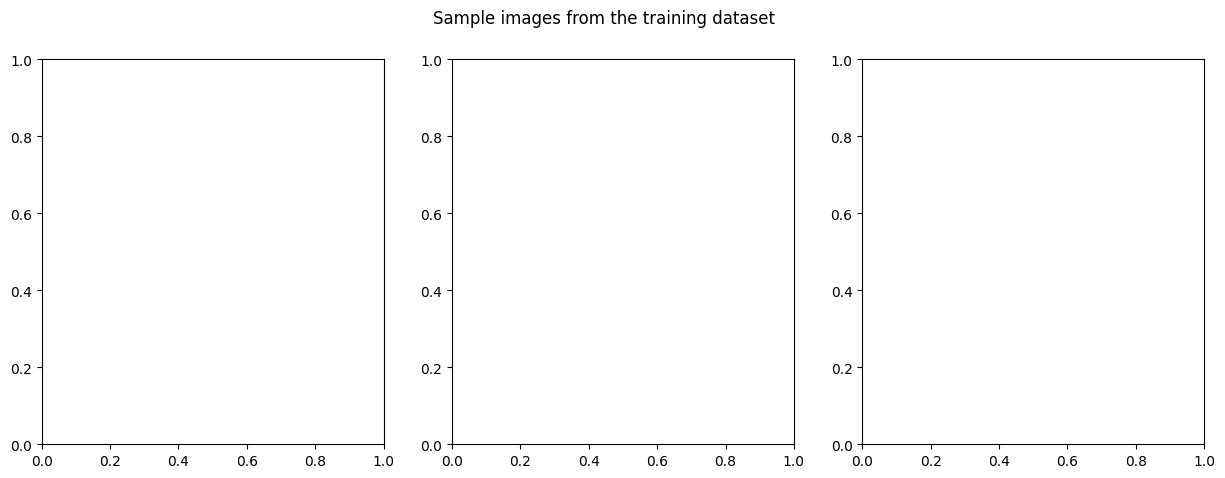

In [8]:
base_precision = 0.553
print(f'\nDenoise')

train_dataset, train_loader, test_dataset, test_loader = get_model_data(transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), EqualizeTransform()]))

precision = evaluate_model(nn.BCELoss().to(device), device, train_loader, test_loader)

equalize_precision = precision

print(f'Precision: {precision*100:.2f}%')

print(f'Improvement: {precision - base_precision:.2f}%')

if precision > base_precision:
    print('The method is an improvement.')

else:
    print('The method is not an improvement.')

print('-' * 20)
print()

In [ ]:
equalize_precision = {}

for method in EqualizationMethod.names:
    print(f'\nDenoise method: {method}')

    train_dataset, train_loader, test_dataset, test_loader = get_model_data(
        transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), EqualizeTransform(EqualizationMethod[method]).to(device)]))

    precision = evaluate_model(nn.BCELoss().to(device), device, train_loader, test_loader)
    
    equalize_precision[method] = precision

    print(f'Precision: {precision*100:.2f}%')

    print(f'Improvement: {precision - base_precision:.2f}%')

    if precision > base_precision:
        print('The method is an improvement.')

    else:
        print('The method is not an improvement.')

    print('-' * 20)
    print()
    break

: 

: 